# Premise
[_The Witcher 2_](http://thewitcher.com/en/witcher2) has a mini ingame that can be played with some of the NPCs, called _Dice_. The game is played between two players. At the beginning both players bet some money, then each of them rolls 5 (6 sided) dices. Both can see the other's dices. After the dices have been rolled, bets can be raised and then each player chooses between 0 and 5 (inclusive) of his/her dices to roll a second time. Once both players have rolled dices a second time, a winner or a tie is decided based on some set of rules that assign ranking to a collection of 5 dices. Detailed rules can be found in the [game's wiki](http://witcher.wikia.com/wiki/Dice_poker_in_The_Witcher_2).

From the [wiki](http://witcher.wikia.com/wiki/Dice_poker_in_The_Witcher_2), the winning combinations are (highest to lowest):
1. __Five-of-a-kind__ - five dice showing the same value
2. __Four-of-a-kind__ - four dice showing the same value
3. __Full House__ - a pair and a three-of-a-kind
4. __Six-high straight__ - dice showing II, III, IV, V and VI
5. __Five-high straight__ - dice showing I, II, III, IV and V
6. __Three-of-a-kind__ - three dice showing the same value
7. __Two pairs__ - dice showing two matched pairs of values
8. __One pair__ - dice showing a single matched pair of values
9. __Nothing__ - none of the above

Two hands are first compared by their states, in the event that two hands have the same state they are compared by their face values, in which case the higher face value wins.

## Notation
In this note, by a __hand__ we will refer to a string of length five containing only digits between 1 and 6, inclusive. A hand represents a collection of five six-sided dices. The sum of all the numbers in a hand will be called its __value__. We will call the 9 winning combinations above the __states__. A number will be assigned to each state, more specifically, we will assign 0 to Nothing, 1 to One pair, 2 to Two pairs and so on. These numbers will be referred to as the __coarse rank__ of a state. To break the tie between two hands with the same state we define a __fine rank__:
> fine rank = coarse rank + value/30

Note that the highest value that a hand can have is 30.

## Plan
Our notion of an __optimal solution__ in this game is the following:
> An optimal solution minimizes the maximum probability of not winning.

In what follows we will find a solution that satisfies this criterion. Given the player's hand and the opponent's hand we will find a subset of the dices in the player's hand which, if rolled, minimizes the chance of not winning. To be more precise, suppose $h_p, h_o \in \mathbb 6^5$ (where $\mathbb 6 = \{1,2,3,4,5,6\}$) represent the player's and the opponent's hand (in code $h_p$ and $h_o$ will be strings not set, but abstractly they are sets). Now, given two subsets $s_p \subseteq h_p$ and $s_o \subseteq h_o$, let us define:
> $P_{!\mathrm{win}}(h_p, s_p; h_o, s_o) := $ The probability that the player will not win if the player and the opponent roll the dices in $s_p$ and $s_o$ respectively.

Now we can articulate what we mean by an optimal solution:
> Given a player's hand $h_p$ and an opponent's hand $h_o$ the optimal solution (for the choice of subset of the player's hand to roll) is:
$$ \underset{s_p \subseteq h_p}{\mathrm{argmin}}\, \underset{s_o \subseteq h_o}{\mathrm{max}}\, P_{!\mathrm{win}}(h_p, s_p; h_o, s_o)\,.$$

# Initialization
Let us begin by loading all the necessary modules.

In [1]:
if(__name__ == '__main__'):
    %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time
from itertools import permutations
from pandas import DataFrame, Series
from scipy.special import factorial
import random
random.seed()

We assign a coarse rank to each of the 9 winning combinations, and define a few utility functions.

In [2]:
# Each state will carry an integer weight
state_rank = {'Five of a Kind':8, 'Four of a Kind':7, 'Full House':6, 'Six High Straight':5, \
               'Five High Straight':4, 'Three of a Kind':3, 'Two Pairs':2, 'Pair':1, 'Nothing':0}

# This serves to catch bugs
def check_hand(hand):
    assert(type(hand) == str and len(hand) == 5 and hand.isdigit())
    
# This serves to catch bugs
def check_roll(roll):
    assert(roll == [] or (type(roll) == list and len(roll) <= 5 and min(roll) >= 0 and max(roll) <= 4))
    
# The "roll" function generates a random hand.
def roll():
    return ''.join([str(random.randint(1,6)) for i in range(5)])

# Some Combinatorics
We need a function to compute the fine rank of a hand. The function is called `rank_fine`.

In [3]:
# the 'decon' function takes in a hand and outputs two lists of the same length, the latter 
# (descendingly ordered) containing the frequencies of numbers that appear in the hand
# and the former contains the numbers that correspond to the frequencies. For example,
# if the hand is '32443', then the outputs will be [4, 3, 2], [2, 2, 1] since there are
# two 4s, two 3s and one 2.
def decon(hand):
    check_hand(hand)
    
    record = Series([])
    for c in hand:
        if int(c) in record:
            record[int(c)] += 1
        else:
            record[int(c)] = 1
    sorted_record = record.sort_values(ascending=False)
                
    return list(sorted_record.index), list(sorted_record.values)

# the 'evaluate' function takes in the output of the dcon function and outputs the state of
# the hand and its value.
def evaluate(occupants, core):
    assert(type(occupants) == list and type(core) == list and len(occupants) == len(core))
    
    face_value = sum(np.array(occupants) * np.array(core))
    
    if 5 in core:
        return 'Five of a Kind', face_value
    
    if 4 in core:
        return 'Four of a Kind', face_value
    
    if 3 in core and 2 in core:
        return 'Full House', face_value
    
    if 1 in core and core.count(1) == 5:
        six_high_face_value = sum([2,3,4,5,6])
        five_high_face_value = sum([1,2,3,4,5])
        if face_value == six_high_face_value:
            return 'Six High Straight', face_value
        elif face_value == five_high_face_value:
            return 'Five High Straight', face_value
        
    if 3 in core:
        return 'Three of a Kind', face_value
    
    if 2 in core:
        if core.count(2) == 2:
            return 'Two Pairs', face_value
        else:
            return 'Pair', face_value
        
    return 'Nothing', face_value

# 'rank_fine' takes in a hand and outputs its fine rank
def rank_fine(hand):
    check_hand(hand)
    
    appearance, core = decon(hand)
    state, value = evaluate(appearance, core)
    return state_rank[state] + value/30

Some combinatorial functions are needed to compute the possible outcomes of a roll and their associated probabilities.

In [4]:
# the 'outcomes' function takes in an integer 0 <= n <= 5 and generates all possible 
# outcomes of rolling n six-sided dices. Each possible outcome is represnted by a 
# length 5 string containing only numerals.
def outcomes(n):
    assert(type(n) == int and n >= 0 and n <= 5)
    
    outcomes_set = {''.join(outcome) for outcome in permutations('111112222233333444445555566666', n)}
    return np.array(list(outcomes_set))

# outcomes is a costly function, therefore it's significantly more efficient to generate all possible outcomes of
# rolling 0, 1, ..., 5 dices and store them in a list. 'Outcome[n]' for 0 <= n <= 5 is a list containing all
# possible outcomes of rolling n six-sided dices.
Outcomes = [outcomes(i) for i in range(6)]

# the 'rank_fine' function is also rather costly considering how many times it will
# need to be used. time cost reduces significantly if we just compute all the ranks
# at the beginning and store them in a dictionary.
rank_f = {hand: rank_fine(str(hand)) for hand in Outcomes[5]}

# 'second_roll_states' takes in a hand and a list (called 'to_roll') of positions of
# dices to roll, then it outputs a 'DataFrame' object with one column titled 'Hand' 
# which contains the hands that can occur if the dices in 'to_roll' are rolled.
def second_roll_states(hand, to_roll=[]):
    check_hand(hand)
    assert(type(to_roll) == list and len(to_roll) < 6)
    
    fixed_positions = set([0,1,2,3,4]) - set(to_roll)
    fixed_dices = ''.join([hand[i] for i in fixed_positions])
    local_outcomes = Outcomes[len(to_roll)]
    start_time = time.time()
    global_outcomes = np.vectorize(lambda x: rank_f[fixed_dices + x])(local_outcomes)
    return DataFrame(global_outcomes, columns=['Hand'])

In [5]:
# 'chances' takes in a hand and a subset to roll and uses 'second_roll_states' to 
# compute all the possible hands that can occur after rolling the subset. Then
# it converts all the possible hands into their fine ranks and then computes the
# probability of each fine rank ocurring. it outputs a 'DataFrame' object with two
# columns, the 'Rank' column contains the possible fine ranks that can occur and
# the 'Probability' column contains their corresponding probability.
def chances(hand, to_roll=[], sort=False):
    check_hand(hand)
    assert(type(to_roll) == list and len(to_roll) < 6)
    
    states = second_roll_states(hand, to_roll)
    total = states.shape[0]
    
    state_probabilities = states['Hand'].value_counts()/total
    chance_table = DataFrame(np.array([state_probabilities.index, state_probabilities.values]).T, columns=['Rank', 'Probability'])
    
    if sort:
        chance_table = chance_table.sort_values('Rank', ascending=False)
        
    return chance_table

A sample output of `chances`, when we roll some dices a second time, is the following:

In [6]:
if(__name__ == '__main__'):
    dices_to_roll = 5
    hand = ''.join([str(random.randint(1,6)) for i in range(5)])
    to_roll = [int(x) for x in list(permutations('01234', dices_to_roll))[random.randint(0, factorial(5)/factorial(5-dices_to_roll)-1)]]
    print('Hand: ' + hand)
    print('To roll: ' + str(to_roll))
    print(chances(hand, to_roll, sort=True))

Hand: 65114
To roll: [3, 0, 4, 1, 2]
         Rank  Probability
102  9.000000     0.000129
105  8.833333     0.000129
101  8.666667     0.000129
103  8.500000     0.000129
104  8.333333     0.000129
100  8.166667     0.000129
97   7.966667     0.000643
92   7.933333     0.000643
90   7.900000     0.000643
73   7.866667     0.001286
87   7.833333     0.000643
93   7.800000     0.000643
94   7.766667     0.000643
79   7.733333     0.001286
70   7.700000     0.001286
88   7.633333     0.000643
85   7.600000     0.001286
71   7.566667     0.001286
96   7.533333     0.000643
76   7.466667     0.001286
81   7.433333     0.001286
91   7.400000     0.000643
89   7.366667     0.000643
86   7.333333     0.000643
84   7.300000     0.001286
99   7.266667     0.000643
95   7.233333     0.000643
98   7.200000     0.000643
72   6.933333     0.001286
77   6.900000     0.001286
..        ...          ...
11   2.666667     0.023148
12   2.633333     0.019290
13   2.600000     0.019290
15   2.566667     

# Computing Losses
The function `p_loss` below is the function $P_{!\mathrm{win}}(h_p, s_p; h_o, s_o)$ mentioned in the __Premise__. In the code below $h_p, s_p, h_o$ and $s_o$ are called `hand1`, `to_roll1`, `hand2` and `to_roll2` respectively.

In [7]:
# 'p_loss' computes the probability of not winning if the player with hand 'hand1'
# rolls the subset 'to_roll1' and the opponent with hand 'hand2' rolls the subset 'to_roll2'.
def p_loss(hand1, to_roll1, hand2, to_roll2):
    check_hand(hand1)
    check_hand(hand2)
    check_roll(to_roll1)
    check_roll(to_roll2)
    
    stime = time.time()
    chances1 = chances(hand1, to_roll1)
    chances2 = chances(hand2, to_roll2)
    
    prod_p = np.outer(chances2['Probability'], chances1['Probability'])
    prod_r = np.vectorize(lambda x: 1 if x >= 1 else 0)(np.divide.outer(chances2['Rank'], chances1['Rank']))
    p_not_win = np.sum(prod_p * prod_r)
    
    # as a cautionary tale, the following line computes the same number as the p_not_win above
    # but takes 10 times as much time, because it uses list comprehension, as opposed to the
    # numpy vector operations above. numpy uses parallel computing which can lead to superb
    # speed boost.
    
    # p_not_win = sum([chances1['Probability'][i1] * chances2['Probability'][i2] for i1 in chances1.index for i2 in chances2.index if chances1['Score'][i1] <= chances2['Score'][i2]])
    
    return p_not_win

# The function 'second_choices' outputs a list of lists. The sublists are lists
# of positions (from 0 to 4) and represents the dices to roll.
def second_choices():
    choices = []
    for i in range(0,32):
        bini = bin(i)[2:]
        bini = ''.join(['0']*(5-len(bini))) + bini
        bini = Series(np.array([c for c in bini]))
        choices.append(list(bini[bini == '1'].index))
    return choices

In the following, the `p_loss_max` function computes $\underset{s_o \subseteq h_o}{\mathrm{max}}\, P_{!\mathrm{win}}(h_p, s_p; h_o, s_o)$. As before, $h_p, s_p$, and $h_o$ are written as `hand1`, `to_roll1`, and `hand2` respectively. There is an optional argument rolls so that when we need to use this function multiple times we can save time by computing `second_choices()` once and then just passing the stored result as argument.

In [8]:
# 'p_loss_max' computes the probability of not winning if the player with hand 'hand1' rolls
# the subset 'to_roll1' when the opponent has the hand 'hand2'. the function goes through
# all the subsets of 'hand2' for the opponent to roll and computes the probability of loss
# using p_loss and then finds the maximum of these probabilities.
def p_loss_max(hand1, to_roll1, hand2, rolls=second_choices()):
    check_hand(hand1)
    check_hand(hand2)
    check_roll(to_roll1)
    
    p_losses = np.vectorize(lambda x: p_loss(hand1, to_roll1, hand2, x))(rolls)
    
    p_max = max(p_losses)
    
    return p_max

# An Optimal Move
All that is left to do is to compute the $\underset{s_p \subseteq h_p}{\mathrm{argmin}}$ part of the formula for the optimizer we mentioned in the __Premise__. For the sake of quick reference, we reproduce the formula for the optimizer:
$$ \underset{s_p \subseteq h_p}{\mathrm{argmin}}\, \underset{s_o \subseteq h_o}{\mathrm{max}}\, P_{!\mathrm{win}}(h_p, s_p; h_o, s_o)\,.$$
Implementing this is the purpose of the last function, the `optimize`.

In [9]:
def optimize(hand1, hand2, rolls = second_choices()):
    check_hand(hand1)
    check_hand(hand2)
    
    roll_p_loss = [[to_roll1, p_loss_max(hand1, to_roll1, hand2, rolls)] for to_roll1 in rolls]
    roll_p_loss = DataFrame(roll_p_loss, columns=['Roll', 'P_loss'])
    min_id = roll_p_loss['P_loss'].idxmin()
    
    return roll_p_loss.loc[min_id]

Finally, let us see how our `optimize` function works for some random test case.

In [10]:
if(__name__ == '__main__'):
    # To use this for the purpose of playing actual games (as in The Witcher 2), replace "roll()" in the following
    # two lines with two length 5 strings containing numbers only representing dices.
    hand_my = roll() # Replace with the player's hand, example: Hand('51342').
    hand_op = roll() # Replace with the opponent's hand, example: Hand('34323').
    #hand_my = '23253'
    #hand_op = '21515'
    print('My hand: ' + hand_my + ', Opponent\'s hand: ' + hand_op)

    start_time = time.time()
    
    opt_choice = optimize(hand_my, hand_op)
    print('Optimal choice: ' + str(opt_choice['Roll']) + ', Max p of loss: ' + str(opt_choice['P_loss']))
    print('Time took: ' + str(time.time()-start_time) + 's.')

My hand: 25352, Opponent's hand: 55655
Optimal choice: [0, 2, 4], Max p of loss: 0.99537037037
Time took: 5.723157644271851s.


## Sanity check
We can see more explicitly how well our `optimize` function works. Since this game is completely symmetric between the two players, if both of them plays optimally, the likelihood of winning for one of them should be 50%, when averaged over a large number of games. We can randomly generate two hands some large number of times, compute the probability of winning for player 1 and the distribution of these probabilities should be symmetric with mean 0.5. Let's see it in action.

Mean: 0.505456092345, Median: 0.512699331276


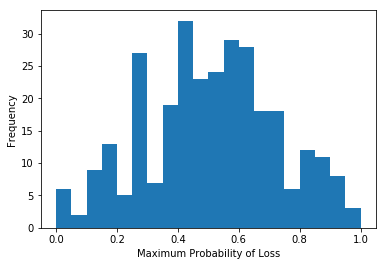

Time took: 1728.3753888607025s.


In [11]:
if(__name__ == '__main__'):
    start_time = time.time()
    sample_size = 300
    n_bins = int(sample_size/15)
    rolls = second_choices()
    p_loss_distro = [optimize(roll(), roll(), rolls=rolls)['P_loss'] for i in range(sample_size)]
    plt.hist(p_loss_distro, bins=n_bins, range=(0,1))
    plt.xlabel('Maximum Probability of Loss')
    plt.ylabel('Frequency')
    print('Mean: ' + str(np.mean(p_loss_distro)) + ', Median: ' + str(np.median(p_loss_distro)))
    plt.show()
    print('Time took: ' + str(time.time()-start_time) + 's.')

The reasonably (considering the size) symmetric looking distribution has mean and median fairly close to 0.5, clearly our optimizer isn't too bad!